## Libraries

In [ ]:
!pip install kaggle  #Install the Kaggle API

In [ ]:
import os

# Set your Kaggle username and key manually
os.environ['KAGGLE_USERNAME'] = "tajkia05"
os.environ['KAGGLE_KEY'] = "6952fda6baede976828c9ccc32346cbe"

# Now you can use kaggle CLI normally
# !kaggle datasets list


In [ ]:
!kaggle datasets download -d zalando-research/fashionmnist --unzip -p /content/  #download the Fashion MNIST dataset

Dataset URL: https://www.kaggle.com/datasets/zalando-research/fashionmnist
License(s): other


In [ ]:
!kaggle datasets download -d oddrationale/mnist-in-csv --unzip -p /content/  #download the MNIST dataset


Dataset URL: https://www.kaggle.com/datasets/oddrationale/mnist-in-csv
License(s): CC0-1.0


In [ ]:
import pandas as pd
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial

## Activaton functions

In [ ]:
class Activation:
    '''
        Activation class:
            this class contail the different activation function.
            for defining the activation functions as object method they should have two mode.


    '''

    def sigmoid(self, z : np.array, t_path : str = 'forward') -> np.array:
        '''
        Sigmoid Activation funciton:

        parameters:
            z : numpy array as input.
            t_path : string input specifying the runnig mode of activation function
                    in forward mode it calculate the output of activation function
                    and in backward mode in return the numerical derivative of the activation
                    funciton.
        out_put:
            s : depending on the "t_path"
            t_path = forward -> s : sigmoid(z)
            t_path = backward -> s : derivative(sigmoid(z))

        '''
        if t_path == 'forward':
            z = np.clip(z, -500, 500)
            s = 1. / (1 + np.exp(-z))
        elif t_path == 'backward':
            s = (1 - z) * z
        return s


    def ReLu(self, z : np.array, slope : float = 1.,  t_path : str = 'forward') -> np.array:
        '''
        ReLu Activation funciton:

        parameters:
            z : numpy array as input.
            slope : this value determine the slope of relu function. Default value is 1.
            t_path : string input specifying the runnig mode of activation function
                    in forward mode it calculate the output of activation function
                    and in backward mode in return the numerical derivative of the activation
                    funciton.
        out_put:
            s : depending on the "t_path"
            t_path = forward -> s : ReLu(z)
            t_path = backward -> s : derivative(ReLu(z))

        '''

        if t_path == 'forward':
            s = np.maximum(0,z)
        elif t_path == 'backward':
            s = (z > 0).astype(float) * slope
        return s

    def LeakyReLu(self, z : np.array, slope : float = 1. ,alpha : float = 0.01, t_path : str = 'forward') -> np.array:
        '''
        LeakyReLu Activation funciton:

        parameters:
            z : numpy array as input.
            slope : this value determine the slope of Leakyrelu function for positvie values. Default value is 1.
            alpha : this value determine the slope of Leakyrelu function for negatvie values. Default value is 1.
            t_path : string input specifying the runnig mode of activation function
                    in forward mode it calculate the output of activation function
                    and in backward mode in return the numerical derivative of the activation
                    funciton.
        out_put:
            s : depending on the "t_path"
            t_path = forward -> s : LeakyReLu(z)
            t_path = backward -> s : derivative(LeakyReLu(z))

        '''
        if t_path == 'forward':
            s = np.where(z > 0, z * slope, alpha * z)
        elif t_path == 'backward':
            s = np.where(z > 0, slope, alpha)
        return s

    def softmax(self, z : np.array, t_path : str = 'forward') -> np.array:

          z_max = np.max(z, axis = 0, keepdims=True)  # Subtract max for numerical stability
          exp_z = np.exp(z - z_max)
          return exp_z / np.sum(exp_z, axis = 0, keepdims=True)


## Loss Functions

In [ ]:
class Loss:
    '''
    Loss funcion class:
    for creating different losses for different taskes.
    this loss functions have two modes.
    forwrd mode : calculate output loss
    backward mode : return derivative of loss function

    '''
    def bceLoss(self, predicted : np.array, actual : np.array, epsilon : float = 1e-15, t_path : str = 'forward'):
        '''
        Binary Cross Entrpy Loss Function
        Two mode loss function


        '''
        predicted = np.clip(predicted, epsilon, 1 - epsilon)
        predicted = predicted.reshape(1, -1)
        actual = actual.reshape(1, -1)
        if t_path == 'forward':
            loss = - (actual * np.log(predicted) + (1 - actual) * np.log(1 - predicted))
            return np.mean(loss)


        if t_path == 'backward':
            m = actual.shape[1]
            return ((predicted - actual)/(predicted*(1 - predicted)))/m

    def cross_entropy_loss(self, predicted: np.array, actual: np.array, class_number, epsilon: float = 1e-15, t_path: str = 'forward'):
        '''
        Multiclass Cross-Entropy Loss Function
        Two-mode (forward or backward) support
        '''
        predicted = np.clip(predicted, epsilon, 1 - epsilon)  # Avoid log(0)

        if t_path == 'forward':
           actual_1 = np.eye(class_number)[actual.flatten()]  # One-hot encode
           actual_1 = actual_1.T
           loss = -np.sum(actual_1 * np.log(predicted), axis=0)  # sum over classes
           return np.mean(loss)  # mean over batch

    def zero_one_loss(self, predicted : np.array, actual : np.array, t_path : str = 'forward'):
        '''
        Zero One Loss Function
        '''
        size = np.squeeze(actual).shape[0]

        if predicted.shape[0] == 1:
          predicted = (predicted >= 0.5).astype(int)
          score = (predicted == actual).sum()/size
        else:
          predicted = np.argmax(predicted, axis=0)
          score = (predicted == actual).sum()/size
        return score


## Data Loader Class

In [ ]:
class Dataset:
    '''
    Dataset class for working with datasets:
        this class create batches of data and return batches in step.
        Parameters:
        Data : np.array. Dataset array without target values. size should be (# features, # instances)
        Label : np.array of Labels
        batch_size : int value the number of instances in each batch
        shuffle : boolean variable determine shuffling the data before batching
    '''
    def __init__(self, Data : np.array, Label : np.array, batch_size : int, shuffle : bool = False):

        self.Data : np.array = Data
        self.Label : np.array = Label.reshape(1, -1)
        self.s : int = 0
        self.batch_size : int = batch_size
        self.e : int = self.Data.shape[1] // self.batch_size

        if shuffle:
            indices : np.array = np.arange(self.Data.shape[1])
            np.random.shuffle(indices)
            self.Data : np.array = self.Data[:, indices]
            self.Label : np.array = self.Label[:, indices]

    def data_loader(self) -> (np.array):
        '''
        data_loader method
        every time this method be called as out put it return a batch of data and label
        '''
        if self.s + self.batch_size >= self.Data.shape[1]:
            x : np.array = self.Data[:, self.s:]
            y : np.array = self.Label[:, self.s:]
            self.s : int = 0
        else:
            x : np.array = self.Data[:, self.s : self.s + self.batch_size + 1]
            y : np.array = self.Label[:, self.s : self.s + self.batch_size + 1]

        self.s += self.batch_size
        return x, y


## Optimizer Class

In [ ]:
class Optimizer:
    '''
    Optimize class:
        class contain different optimizer


    '''
    def __init__(self):
        self.m = {}
        self.v = {}
        self.t = 0
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.epsilon = 1e-8

    def bgd_optimizer(self, params : dict, derivatives : dict, alpha : float = 0.01) -> dict:
        for layer in range(len(params)):
            params['Layer_'+ str(layer)]['W_' + str(layer)] -= alpha * derivatives['Layer_'+ str(layer)]['dW_' + str(layer)]
            params['Layer_'+ str(layer)]['b_' + str(layer)] -= alpha * derivatives['Layer_'+ str(layer)]['db_' + str(layer)]

        return params

    def adam_optimizer(self, params: dict, derivatives: dict, alpha: float = 0.001) -> dict:
      self.t += 1  # Increment timestep

      for layer in range(len(params)):
          for param_key in ['W', 'b']:
              name = f'{param_key}_{layer}'
              dname = f'd{param_key}_{layer}'
              layer_key = f'Layer_{layer}'

              # Initialize m and v if not present
              if layer_key not in self.m:
                  self.m[layer_key] = {}
                  self.v[layer_key] = {}

              if name not in self.m[layer_key]:
                  self.m[layer_key][name] = np.zeros_like(params[layer_key][name])
                  self.v[layer_key][name] = np.zeros_like(params[layer_key][name])

              # Update moments
              self.m[layer_key][name] = self.beta1 * self.m[layer_key][name] + (1 - self.beta1) * derivatives[layer_key][dname]
              self.v[layer_key][name] = self.beta2 * self.v[layer_key][name] + (1 - self.beta2) * (derivatives[layer_key][dname] ** 2)

              # Bias correction
              m_hat = self.m[layer_key][name] / (1 - self.beta1 ** self.t)
              v_hat = self.v[layer_key][name] / (1 - self.beta2 ** self.t)

              # Parameter update
              params[layer_key][name] -= alpha * m_hat / (np.sqrt(v_hat) + self.epsilon)

      return params


## Saving and loading Models

In [ ]:
def save_best_model(params, filename):
    """Save best model parameters to a file."""
    filepath = f"/content/{filename}_best_model.npy"  # Ensure the correct path
    np.save(filepath, params) # Save model parameters

def load_best_model(filename):
    """Load best model parameters from a file."""
    filepath = f"/content/{filename}_best_model.npy"
    return np.load(filepath, allow_pickle=True).item()


In [ ]:
def save_error_history(error_history, filename):
    """Save error history to /content/filename."""
    filepath = f"/content/{filename}_error_history.npy"
    np.save(filepath, np.array(error_history))  # Convert list to numpy array before saving
def load_error_history(filename):
    """load error history to /content/filename."""
    filepath = f"/content/{filename}_error_history.npy"
    return np.load(filepath, allow_pickle=True)

## Neural Net class

In [ ]:
class NN:

    '''
    Neural Net Class


    '''
    def __init__(self, file_name, input_shape : int, neuron_list : list[int], loss_fn : Loss ,activaion_f_list : list[str] = None, param_init : list[tuple] = None, name : str = "NN"):

        self.input_shape : int = input_shape # number of features

        self.neuron_list : list[int] = neuron_list # list contain the number of neurons in different layers
        self.parameters : dict = {} # dictionary of the model parameters
        self.derivatives : dict = {} # dictionary of the gradients
        self.forward_path_mem : dict = {} # dictionary of forward path memory
        self.activation_f_list = activaion_f_list # list of activation functions. for each layer have to be one activation function
        self._initia_parameters(param_init) # list of different initilizer of the different layer weights list of string
        self.loss_fn = loss_fn
        self.Layer = len(self.neuron_list) - 1
        self.num_class = self.neuron_list[-1]
        self.model_name = name
        self.file_name = file_name



    def _initia_parameters(self, p : list[tuple]):
        '''
        initialing weights

        '''

        if p == None:
            p = []
            for i in range(len(self.neuron_list)):
                p.append((('normal', 0.01)))

        for layer, arg in enumerate(self.neuron_list):

            if layer == 0:
                self.parameters["Layer_" + str(layer)] = {"W_"+ str(layer) : self._random_init(self.input_shape, arg, p[layer]),
                                                        "b_"+ str(layer) : np.zeros((arg, 1)),}
            else:
                self.parameters["Layer_" + str(layer)] = {"W_"+ str(layer) : self._random_init(self.neuron_list[layer - 1], arg, p[layer]),

                                                        "b_"+ str(layer) : np.zeros((arg, 1)),}



    def _random_init(self, input_s : int, output_s : int, p : tuple) -> np.array:
        if p[0] == 'normal':
            W = np.random.randn(output_s,input_s) * p[1]
        return W



    def train(self, epochs : int, Data_loader_obj, optimizer, x_val = None, y_val = None):
        loss_history = []
        for epoch in range(epochs):

            total_loss = 0
            best_error = np.inf
            size = 0
            for i in range(Data_loader_obj.e):
                X, y = Data_loader_obj.data_loader()

                if X.size == 0:
                    break

                size += X.shape[1]
                self._forward_path(X)

                predicted = self.forward_path_mem['Layer_' + str(self.Layer)]["A_" + str(self.Layer)]
                loss_value = self.loss_fn(predicted, y, t_path = 'forward')
                total_loss += loss_value

                self._backward_path(X, y)

                self.parameters = optimizer(self.parameters, self.derivatives)

            av_loss = total_loss/size

            if av_loss < best_error:
                best_errpr = av_loss
                best_params = self.parameters.copy()
                save_best_model(best_params, self.file_name)
            loss_history.append(av_loss)

            if (epoch + 1) % 10 == 0:

                print(f"epoch {epoch + 1}/{epochs}")
                print(f"The total loss is {av_loss}")
                print("==========================================\n")


        loss_history = np.array(loss_history)
        # Save error history at the end of training
        save_error_history(loss_history, self.file_name)


    def predict(self, X):
        self._forward_path(X)
        predicted_prob = self.forward_path_mem['Layer_' + str(self.Layer)]["A_" + str(self.Layer)]
        return {'raw' :predicted_prob, 'class' : np.argmax(predicted_prob, axis=0)}



    def _forward_path(self, Data : np.array): # forward path funciton

        A = Data
        for layer in range(len(self.neuron_list)):
            Z = np.dot(self.parameters["Layer_" + str(layer)]["W_"+ str(layer)], A)
            Z = Z + self.parameters["Layer_" + str(layer)]["b_"+ str(layer)]
            A = self.activation_f_list[layer](Z, t_path = 'forward')
            self.forward_path_mem['Layer_' + str(layer)] = {"Z_" + str(layer) : Z, "A_" + str(layer) : A}



    def _backward_path(self, Data, Label): #backward path

        if self.num_class > 2:
            Label_1 = np.eye(self.num_class)[Label]
            Label_1 = np.squeeze(Label_1).T
        else:
            Label_1 = Label

        for layer in range(self.Layer + 1)[::-1]:

            if layer == self.Layer:
                dZ = (self.forward_path_mem['Layer_' + str(layer)]["A_" + str(layer)] - Label_1)/(Data.shape[1])
                dW = np.dot(dZ, (self.forward_path_mem['Layer_' + str(layer - 1)]["A_" + str(layer - 1)]).T)
                db = np.sum(dZ, axis=1, keepdims=True)
                self.derivatives['Layer_'+str(layer)] = {'dW_'+str(layer) : dW, 'db_'+str(layer) : db}


            elif layer == 0:
                dZ = np.dot((self.parameters['Layer_' + str(layer + 1)]['W_'+ str(layer + 1)]).T, dZ) * self.activation_f_list[layer](self.forward_path_mem['Layer_' + str(layer)]["A_" + str(layer)], t_path = 'backward')
                dW = np.dot(dZ, Data.T)
                db = np.sum(dZ, axis=1, keepdims=True)
                self.derivatives['Layer_'+str(layer)] = {'dW_'+str(layer) : dW, 'db_'+str(layer) : db}

            else:

                dZ = np.dot((self.parameters['Layer_' + str(layer + 1)]['W_'+ str(layer + 1)]).T, dZ) * self.activation_f_list[layer](self.forward_path_mem['Layer_' + str(layer)]["A_" + str(layer)], t_path = 'backward')
                dW = np.dot(dZ, (self.forward_path_mem['Layer_' + str(layer - 1)]["A_" + str(layer - 1)]).T)
                db = np.sum(dZ, axis=1, keepdims=True)
                self.derivatives['Layer_'+str(layer)] = {'dW_'+str(layer) : dW, 'db_'+str(layer) : db}


## Plot loss curve

In [ ]:
def plot_loss_curves(loss_lists, names, layer_lists = None, title = "different models"):
    """
    Plots multiple loss curves on the same graph.

    Parameters:
    loss_lists (list of lists): Each inner list contains loss values over epochs.
    names (list of str): Names corresponding to each loss list for the legend.
    """
    if len(loss_lists) != len(names):
      if len(names) == 1:
        names = names * len(loss_lists)
        plt.figure(figsize=(10, 5))
        for loss, name, layer in zip(loss_lists, names,layer_lists):
            plt.plot(range(1, len(loss) + 1), loss, label=layer)

        plt.xlabel("Epochs")
        plt.ylabel("Loss Value")
        plt.title("Loss Curves - Convergence for " + title)
        plt.legend()
        plt.grid(True)
        plt.show()
      else:
        raise ValueError("Number of loss lists and names must be the same")
    else:
      plt.figure(figsize=(10, 5))
      for loss, name in zip(loss_lists, names):
          plt.plot(range(1, len(loss) + 1), loss, label=name)

      plt.xlabel("Epochs")
      plt.ylabel("Loss Value")
      plt.title("Loss Curves - Convergence for " + title)
      plt.legend()
      plt.grid(True)
      plt.show()


## MNIST

### Data load

In [ ]:
# Load Dataset
mnist_train = pd.read_csv("/content/mnist_train.csv")
mnist_test = pd.read_csv("/content/mnist_test.csv")

# Separate features and labels
mnist_x_train = mnist_train.drop('label', axis=1).values
mnist_y_train = mnist_train['label'].values
mnist_x_test = mnist_test.drop('label', axis=1).values
mnist_y_test = mnist_test['label'].values


# Print shapes to confirm
print("X_train shape:", mnist_x_train.shape)
print("y_train shape:", mnist_y_train.shape)
print("X_test shape:", mnist_x_test.shape)
print("y_test shape:", mnist_y_test.shape)

#Reshape
mnist_y_train = mnist_y_train.reshape(1, mnist_y_train.size)
mnist_x_train = mnist_x_train.T

mnist_y_test= mnist_y_test.reshape(1, mnist_y_test.size)
mnist_x_test = mnist_x_test.T


X_train shape: (60000, 784)
y_train shape: (60000,)
X_test shape: (10000, 784)
y_test shape: (10000,)


### model train

In [ ]:
# Set D and L
D = mnist_x_train
L = mnist_y_train

D_test = mnist_x_test
L_test = mnist_y_test


loss = Loss()
loss_fn = partial(loss.cross_entropy_loss, class_number = 10)


act = Activation()


Dataset_obj = Dataset(D, L, batch_size=64, shuffle=True)

optim = Optimizer()
opt_fn = optim.adam_optimizer #optim.adam_optimizer # or optimizer.bgd_optimizer

In [ ]:
Accuracy = Loss()

#### 3 layer different activation

##### Sigmoid

In [ ]:
model3_sig_mnist = NN(input_shape=D.shape[0], neuron_list=[128, 64, 10], loss_fn=loss_fn, activaion_f_list=[act.sigmoid, act.sigmoid, act.softmax], file_name = "mnist_3layer_128_64_sigmoid")

# train model
model3_sig_mnist.train(epochs = 100, Data_loader_obj=Dataset_obj, optimizer= opt_fn)

epoch 10/100
The total loss is 0.010929869143690278

epoch 20/100
The total loss is 0.0070346036869177305

epoch 30/100
The total loss is 0.006413365560673147

epoch 40/100
The total loss is 0.005925140610689667

epoch 50/100
The total loss is 0.005699412542591993

epoch 60/100
The total loss is 0.005627316839924072

epoch 70/100
The total loss is 0.005176079685673728

epoch 80/100
The total loss is 0.004811279050559728

epoch 90/100
The total loss is 0.004734957941365562

epoch 100/100
The total loss is 0.00467198795989507



In [ ]:
out = model3_sig_mnist.predict(D)
print(out['raw'].shape)


(10, 60000)


In [ ]:
model3_sig_mnist_params = load_best_model(filename = "mnist_3layer_128_64_sigmoid")
model3_sig_mnist.parameters = model3_sig_mnist_params
Train_acc_3_sig_mnist = Accuracy.zero_one_loss(model3_sig_mnist.predict(D)['raw'], L) * 100
print(f'Train Accuracy: {Train_acc_3_sig_mnist: .2f} %')

Validation_acc_3_sig_mnist = Accuracy.zero_one_loss(model3_sig_mnist.predict(D_test)['raw'], L_test) * 100
print(f'Validation Accuracy: {Validation_acc_3_sig_mnist: .2f} %')

Train Accuracy:  91.30 %
Validation Accuracy:  90.82 %


##### ReLu

In [ ]:
loss = Loss()
loss_fn = partial(loss.cross_entropy_loss, class_number = 10)


act = Activation()


Dataset_obj = Dataset(D, L, batch_size=64, shuffle=True)

optim = Optimizer()
opt_fn = optim.adam_optimizer #optim.adam_optimizer # or optimizer.bgd_optimizer

In [ ]:
model3_ReLu_mnist = NN(input_shape=D.shape[0], neuron_list=[128, 64, 10], loss_fn=loss_fn, activaion_f_list=[act.ReLu, act.ReLu, act.softmax], file_name = "mnist_3layer_128_64_ReLu")

# train model
model3_ReLu_mnist.train(epochs = 100, Data_loader_obj=Dataset_obj, optimizer= opt_fn)

epoch 10/100
The total loss is 0.0007983718888439209

epoch 20/100
The total loss is 0.0005159516458410197

epoch 30/100
The total loss is 0.0004119446408150394

epoch 40/100
The total loss is 0.0004027334387094992

epoch 50/100
The total loss is 0.00040881289569354146

epoch 60/100
The total loss is 0.0003369685581335103

epoch 70/100
The total loss is 0.00021566076958597983

epoch 80/100
The total loss is 0.0002789622575577871

epoch 90/100
The total loss is 0.000260770113980603

epoch 100/100
The total loss is 0.00023511201513301482



In [ ]:
model3_ReLu_mnist_params = load_best_model(filename = "mnist_3layer_128_64_ReLu")
model3_ReLu_mnist.parameters = model3_ReLu_mnist_params
Train_acc_3_ReLu_mnist = Accuracy.zero_one_loss(model3_ReLu_mnist.predict(D)['raw'], L) * 100
print(f'Train Accuracy: {Train_acc_3_ReLu_mnist: .2f} %')

Validation_acc_3_ReLu_mnist = Accuracy.zero_one_loss(model3_ReLu_mnist.predict(D_test)['raw'], L_test) * 100
print(f'Validation Accuracy: {Validation_acc_3_ReLu_mnist: .2f} %')

Train Accuracy:  99.69 %
Validation Accuracy:  96.81 %


##### LeakyReLu

In [ ]:
loss = Loss()
loss_fn = partial(loss.cross_entropy_loss, class_number = 10)


act = Activation()


Dataset_obj = Dataset(D, L, batch_size=64, shuffle=True)

optim = Optimizer()
opt_fn = optim.adam_optimizer #optim.adam_optimizer # or optimizer.bgd_optimizer

In [ ]:
model3_LeakyReLu_mnist = NN(input_shape=D.shape[0], neuron_list=[128, 64, 10], loss_fn=loss_fn, activaion_f_list=[act.LeakyReLu, act.LeakyReLu, act.softmax], file_name = "mnist_3layer_128_64_LeakyReLu")

# train model
model3_LeakyReLu_mnist.train(epochs = 100, Data_loader_obj=Dataset_obj, optimizer= opt_fn)

epoch 10/100
The total loss is 0.0006716886706358325

epoch 20/100
The total loss is 0.0004873735800450139

epoch 30/100
The total loss is 0.00034515146687369994

epoch 40/100
The total loss is 0.00025876173805156706

epoch 50/100
The total loss is 0.0002708376832588171

epoch 60/100
The total loss is 0.00023356736178724156

epoch 70/100
The total loss is 0.00021882464227577142

epoch 80/100
The total loss is 0.00023004703398616026

epoch 90/100
The total loss is 0.00026349514193963424

epoch 100/100
The total loss is 0.0002659699774282967



In [ ]:
model3_LeakyReLu_mnist_params = load_best_model(filename = "mnist_3layer_128_64_LeakyReLu")
model3_LeakyReLu_mnist.parameters = model3_LeakyReLu_mnist_params
Train_acc_3_LeakyReLu_mnist = Accuracy.zero_one_loss(model3_LeakyReLu_mnist.predict(D)['raw'], L) * 100
print(f'Train Accuracy: {Train_acc_3_LeakyReLu_mnist: .2f} %')

Validation_acc_3_LeakyReLu_mnist = Accuracy.zero_one_loss(model3_LeakyReLu_mnist.predict(D_test)['raw'], L_test) * 100
print(f'Validation Accuracy: {Validation_acc_3_LeakyReLu_mnist: .2f} %')

Train Accuracy:  99.82 %
Validation Accuracy:  97.79 %


##### Plot the error curve

In [ ]:
A_names = ["Sigmoid", "ReLu", "LeakyReLu"]

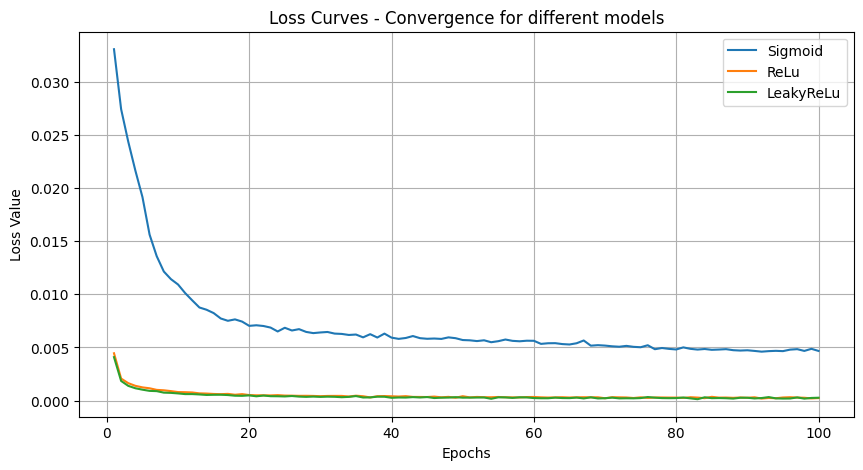

In [ ]:
err_his_3layer_sig_mnist = load_error_history("mnist_3layer_128_64_sigmoid")
err_his_3layer_ReLu_mnist = load_error_history("mnist_3layer_128_64_ReLu")
err_his_3layer_LeakyReLu_mnist = load_error_history("mnist_3layer_128_64_LeakyReLu")
Err_his_3layer_mnist = [err_his_3layer_sig_mnist, err_his_3layer_ReLu_mnist, err_his_3layer_LeakyReLu_mnist]
plot_loss_curves(Err_his_3layer_mnist, A_names, "Mnist")

#### Different layers for LeakyReLu activation

##### 2 layer

In [ ]:
loss = Loss()
loss_fn = partial(loss.cross_entropy_loss, class_number = 10)


act = Activation()


Dataset_obj = Dataset(D, L, batch_size=64, shuffle=True)

optim = Optimizer()
opt_fn = optim.adam_optimizer #optim.adam_optimizer # or optimizer.bgd_optimizer

In [ ]:
model2_LeakyReLu_mnist = NN(input_shape=D.shape[0], neuron_list=[128, 10], loss_fn=loss_fn, activaion_f_list=[act.LeakyReLu, act.softmax], file_name = "mnist_2layer_128_LeakyReLu")

# train model
model2_LeakyReLu_mnist.train(epochs = 100, Data_loader_obj=Dataset_obj, optimizer= opt_fn)

epoch 10/100
The total loss is 0.0020066464525436123

epoch 20/100
The total loss is 0.0015497040756855837

epoch 30/100
The total loss is 0.0015496060487775014

epoch 40/100
The total loss is 0.001373073755627365

epoch 50/100
The total loss is 0.0012842132701649908

epoch 60/100
The total loss is 0.001245975287095136

epoch 70/100
The total loss is 0.0010735106754600852

epoch 80/100
The total loss is 0.0010314593105797325

epoch 90/100
The total loss is 0.0010100786543783267

epoch 100/100
The total loss is 0.0011013985703733308



In [ ]:
model2_LeakyReLu_mnist_params = load_best_model(filename = "mnist_2layer_128_LeakyReLu")
model2_LeakyReLu_mnist.parameters = model2_LeakyReLu_mnist_params
Train_acc_2_LeakyReLu_mnist = Accuracy.zero_one_loss(model2_LeakyReLu_mnist.predict(D)['raw'], L) * 100
print(f'Train Accuracy: {Train_acc_2_LeakyReLu_mnist: .2f} %')

Validation_acc_2_LeakyReLu_mnist = Accuracy.zero_one_loss(model2_LeakyReLu_mnist.predict(D_test)['raw'], L_test) * 100
print(f'Validation Accuracy: {Validation_acc_2_LeakyReLu_mnist: .2f} %')

Train Accuracy:  99.54 %
Validation Accuracy:  96.76 %


##### 4 layer

In [ ]:
D.shape[0]

In [ ]:
loss = Loss()
loss_fn = partial(loss.cross_entropy_loss, class_number = 10)


act = Activation()


Dataset_obj = Dataset(D, L, batch_size=64, shuffle=True)

optim = Optimizer()
opt_fn = optim.adam_optimizer #optim.adam_optimizer # or optimizer.bgd_optimizer

In [ ]:
model4_LeakyReLu_mnist = NN(input_shape=D.shape[0], neuron_list=[128, 64, 32, 10], loss_fn=loss_fn, activaion_f_list=[act.LeakyReLu, act.LeakyReLu, act.LeakyReLu, act.softmax], file_name = "mnist_4layer_128_64_32_LeakyReLu")

# train model
model4_LeakyReLu_mnist.train(epochs = 100, Data_loader_obj=Dataset_obj, optimizer= opt_fn)

epoch 10/100
The total loss is 0.0005966514360662145

epoch 20/100
The total loss is 0.00031803755929134383

epoch 30/100
The total loss is 0.00027459463749088595

epoch 40/100
The total loss is 0.0002554101070278717

epoch 50/100
The total loss is 0.00016435958616049416

epoch 60/100
The total loss is 0.00012310122057083425

epoch 70/100
The total loss is 0.00013254515205619036

epoch 80/100
The total loss is 6.826293119228684e-05

epoch 90/100
The total loss is 9.706111529531835e-05

epoch 100/100
The total loss is 8.54185102228631e-05



In [ ]:
model4_LeakyReLu_mnist_params = load_best_model(filename = "mnist_4layer_128_64_32_LeakyReLu")
model4_LeakyReLu_mnist.parameters = model4_LeakyReLu_mnist_params
Train_acc_4_LeakyReLu_mnist = Accuracy.zero_one_loss(model4_LeakyReLu_mnist.predict(D)['raw'], L) * 100
print(f'Train Accuracy: {Train_acc_4_LeakyReLu_mnist: .2f} %')

Validation_acc_4_LeakyReLu_mnist = Accuracy.zero_one_loss(model4_LeakyReLu_mnist.predict(D_test)['raw'], L_test) * 100
print(f'Validation Accuracy: {Validation_acc_4_LeakyReLu_mnist: .2f} %')

Train Accuracy:  99.95 %
Validation Accuracy:  98.15 %


##### Plot the error curve

In [ ]:
A_names = ["LeakyReLu"]
L_names = ["2 Layer", "3 Layer", "4 Layer"]

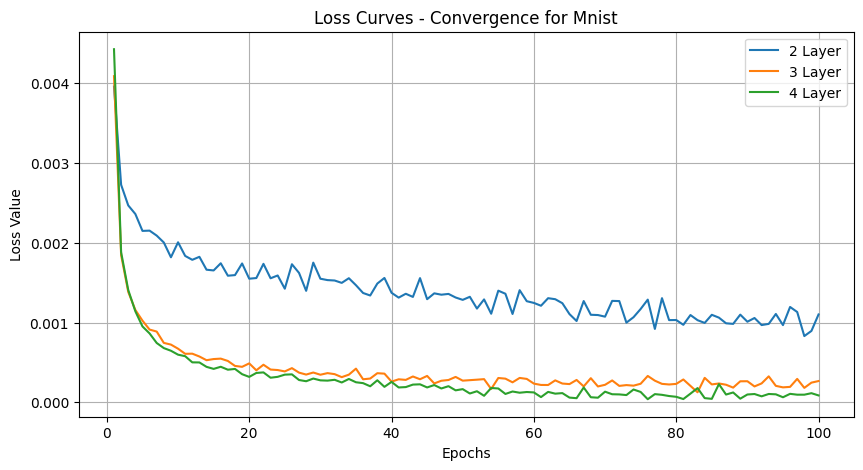

In [ ]:
err_his_2layer_LeakyReLu_mnist = load_error_history("mnist_2layer_128_LeakyReLu")
err_his_3layer_LeakyReLu_mnist = load_error_history("mnist_3layer_128_64_LeakyReLu")
err_his_4layer_LeakyReLu_mnist = load_error_history("mnist_4layer_128_64_32_LeakyReLu")
Err_his_3model_mnist = [err_his_2layer_LeakyReLu_mnist, err_his_3layer_LeakyReLu_mnist, err_his_4layer_LeakyReLu_mnist]
plot_loss_curves(Err_his_3model_mnist, A_names, L_names, title = "Mnist")

## FashionMNIST

### Data load

In [ ]:
# Load Dataset
fmnist_train = pd.read_csv("/content/fashion-mnist_train.csv")
fmnist_test = pd.read_csv("/content/fashion-mnist_test.csv")

# Separate features and labels
fmnist_x_train = fmnist_train.drop('label', axis=1).values
fmnist_y_train = fmnist_train['label'].values
fmnist_x_test = fmnist_test.drop('label', axis=1).values
fmnist_y_test = fmnist_test['label'].values

# Normalize pixel values
# X_train = X_train / 255.0
# X_test = X_test / 255.0


# Print shapes to confirm
print("X_train shape:", fmnist_x_train.shape)
print("y_train shape:", fmnist_y_train.shape)
print("X_test shape:", fmnist_x_test.shape)
print("y_test shape:", fmnist_y_test.shape)

#Reshape
fmnist_y_train = fmnist_y_train.reshape(1, fmnist_y_train.size)
fmnist_x_train = fmnist_x_train.T

fmnist_y_test= fmnist_y_test.reshape(1, fmnist_y_test.size)
fmnist_x_test = fmnist_x_test.T


X_train shape: (60000, 784)
y_train shape: (60000,)
X_test shape: (10000, 784)
y_test shape: (10000,)


### model train

In [ ]:
# Set D and L
D = fmnist_x_train
L = fmnist_y_train

D_test = fmnist_x_test
L_test = fmnist_y_test



loss = Loss()
loss_fn = partial(loss.cross_entropy_loss, class_number = 10)


act = Activation()


Dataset_obj = Dataset(D, L, batch_size=64, shuffle=True)

optim = Optimizer()
opt_fn = optim.adam_optimizer #optim.adam_optimizer # or optimizer.bgd_optimizer

In [ ]:
Accuracy = Loss()

#### 3 layer different activation

##### Sigmoid

In [ ]:
model3_sig_fmnist = NN(input_shape=D.shape[0], neuron_list=[128, 64, 10], loss_fn=loss_fn, activaion_f_list=[act.sigmoid, act.sigmoid, act.softmax], file_name = "fmnist_3layer_128_64_sigmoid")

# train model
model3_sig_fmnist.train(epochs = 100, Data_loader_obj=Dataset_obj, optimizer= opt_fn)

epoch 10/100
The total loss is 0.010292523607088835

epoch 20/100
The total loss is 0.009278647870403072

epoch 30/100
The total loss is 0.009171021580932923

epoch 40/100
The total loss is 0.008807441158907414

epoch 50/100
The total loss is 0.008412867525878737

epoch 60/100
The total loss is 0.008297337214903527

epoch 70/100
The total loss is 0.008136189129081588

epoch 80/100
The total loss is 0.007645379476618081

epoch 90/100
The total loss is 0.007791255862215183

epoch 100/100
The total loss is 0.007701067779508275



In [ ]:
model3_sig_fmnist_params = load_best_model(filename = "fmnist_3layer_128_64_sigmoid")
model3_sig_fmnist.parameters = model3_sig_fmnist_params
Train_acc_3_sig_fmnist = Accuracy.zero_one_loss(model3_sig_fmnist.predict(D)['raw'], L) * 100
print(f'Train Accuracy: {Train_acc_3_sig_fmnist: .2f} %')

Validation_acc_3_sig_fmnist = Accuracy.zero_one_loss(model3_sig_fmnist.predict(D)['raw'], L) * 100
print(f'Validation Accuracy: {Validation_acc_3_sig_fmnist: .2f} %')


Train Accuracy:  83.07 %
Validation Accuracy:  83.07 %


##### ReLu

In [ ]:
loss = Loss()
loss_fn = partial(loss.cross_entropy_loss, class_number = 10)


act = Activation()


Dataset_obj = Dataset(D, L, batch_size=64, shuffle=True)

optim = Optimizer()
opt_fn = optim.adam_optimizer #optim.adam_optimizer # or optimizer.bgd_optimizer

In [ ]:
model3_ReLu_fmnist = NN(input_shape=D.shape[0], neuron_list=[128, 64, 10], loss_fn=loss_fn, activaion_f_list=[act.ReLu, act.ReLu, act.softmax], file_name = "fmnist_3layer_128_64_ReLu")

# train model
model3_ReLu_fmnist.train(epochs = 100, Data_loader_obj=Dataset_obj, optimizer= opt_fn)

epoch 10/100
The total loss is 0.004652971752069191

epoch 20/100
The total loss is 0.004138456396612184

epoch 30/100
The total loss is 0.0037168730278029833

epoch 40/100
The total loss is 0.0035390991722234386

epoch 50/100
The total loss is 0.003498577397517224

epoch 60/100
The total loss is 0.0033261686604992664

epoch 70/100
The total loss is 0.0032989093428192557

epoch 80/100
The total loss is 0.002984151587315105

epoch 90/100
The total loss is 0.0031411059352983313

epoch 100/100
The total loss is 0.003200425170988261



In [ ]:
model3_ReLu_fmnist_params = load_best_model(filename = "fmnist_3layer_128_64_ReLu")
model3_ReLu_fmnist.parameters = model3_ReLu_fmnist_params
Train_acc_3_ReLu_fmnist = Accuracy.zero_one_loss(model3_ReLu_fmnist.predict(D)['raw'], L) * 100
print(f'Train Accuracy: {Train_acc_3_ReLu_fmnist: .2f} %')


Validation_acc_3_ReLu_fmnist = Accuracy.zero_one_loss(model3_ReLu_fmnist.predict(D)['raw'], L) * 100
print(f'Validation Accuracy: {Validation_acc_3_ReLu_fmnist: .2f} %')


Train Accuracy:  92.81 %
Validation Accuracy:  92.81 %


##### LeakyReLu

In [ ]:
loss = Loss()
loss_fn = partial(loss.cross_entropy_loss, class_number = 10)


act = Activation()


Dataset_obj = Dataset(D, L, batch_size=64, shuffle=True)

optim = Optimizer()
opt_fn = optim.adam_optimizer #optim.adam_optimizer # or optimizer.bgd_optimizer

In [ ]:
model3_LeakyReLu_fmnist = NN(input_shape=D.shape[0], neuron_list=[128, 64, 10], loss_fn=loss_fn, activaion_f_list=[act.LeakyReLu, act.LeakyReLu, act.softmax], file_name = "fmnist_3layer_128_64_LeakyReLu")

# train model
model3_LeakyReLu_fmnist.train(epochs = 100, Data_loader_obj=Dataset_obj, optimizer= opt_fn)

epoch 10/100
The total loss is 0.004607210637398368

epoch 20/100
The total loss is 0.004099748810952517

epoch 30/100
The total loss is 0.0037418207655483295

epoch 40/100
The total loss is 0.0033238173449328845

epoch 50/100
The total loss is 0.0032233363834058355

epoch 60/100
The total loss is 0.0029357765452430774

epoch 70/100
The total loss is 0.0025959094551054746

epoch 80/100
The total loss is 0.002665489018703223

epoch 90/100
The total loss is 0.002591819370379294

epoch 100/100
The total loss is 0.002456029342661979



In [ ]:
model3_LeakyReLu_fmnist_params = load_best_model(filename = "fmnist_3layer_128_64_LeakyReLu")
model3_LeakyReLu_fmnist.parameters = model3_LeakyReLu_fmnist_params
Train_acc_3_LeakyReLu_fmnist = Accuracy.zero_one_loss(model3_LeakyReLu_fmnist.predict(D)['raw'], L) * 100
print(f'Train Accuracy: {Train_acc_3_LeakyReLu_fmnist: .2f} %')

Validation_acc_3_LeakyReLu_fmnist = Accuracy.zero_one_loss(model3_LeakyReLu_fmnist.predict(D)['raw'], L) * 100
print(f'Validation Accuracy: {Validation_acc_3_LeakyReLu_fmnist: .2f} %')

Train Accuracy:  93.51 %
Validation Accuracy:  93.51 %


##### Plot the error curve

In [ ]:
A_names = ["Sigmoid", "ReLu", "LeakyReLu"]

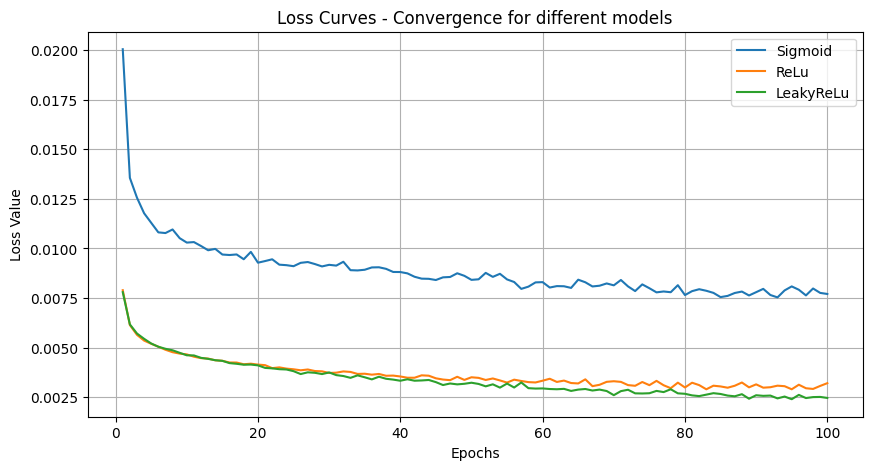

In [ ]:
err_his_3layer_sig_fmnist = load_error_history("fmnist_3layer_128_64_sigmoid")
err_his_3layer_ReLu_fmnist = load_error_history("fmnist_3layer_128_64_ReLu")
err_his_3layer_LeakyReLu_fmnist = load_error_history("fmnist_3layer_128_64_LeakyReLu")
Err_his_3layer_fmnist = [err_his_3layer_sig_fmnist, err_his_3layer_ReLu_fmnist, err_his_3layer_LeakyReLu_fmnist]
plot_loss_curves(Err_his_3layer_fmnist, A_names, "FashionMnist")

#### Different layers for LeakyReLu activation

##### 2 layer

In [ ]:
loss = Loss()
loss_fn = partial(loss.cross_entropy_loss, class_number = 10)


act = Activation()


Dataset_obj = Dataset(D, L, batch_size=64, shuffle=True)

optim = Optimizer()
opt_fn = optim.adam_optimizer #optim.adam_optimizer # or optimizer.bgd_optimizer

In [ ]:
model2_LeakyReLu_fmnist = NN(input_shape=D.shape[0], neuron_list=[128, 10], loss_fn=loss_fn, activaion_f_list=[act.LeakyReLu, act.softmax], file_name = "fmnist_2layer_128_LeakyReLu")

# train model
model2_LeakyReLu_fmnist.train(epochs = 100, Data_loader_obj=Dataset_obj, optimizer= opt_fn)

epoch 10/100
The total loss is 0.006160093135555865

epoch 20/100
The total loss is 0.005723869025050484

epoch 30/100
The total loss is 0.005483147702131672

epoch 40/100
The total loss is 0.00539770951929642

epoch 50/100
The total loss is 0.005097273843780417

epoch 60/100
The total loss is 0.004950230747926866

epoch 70/100
The total loss is 0.004848885713987315

epoch 80/100
The total loss is 0.004725165625446034

epoch 90/100
The total loss is 0.0047989492565376395

epoch 100/100
The total loss is 0.0046009162918871785



In [ ]:
model2_LeakyReLu_fmnist_params = load_best_model(filename = "fmnist_2layer_128_LeakyReLu")
model2_LeakyReLu_fmnist.parameters = model2_LeakyReLu_fmnist_params
Train_acc_2_LeakyReLu_fmnist = Accuracy.zero_one_loss(model2_LeakyReLu_fmnist.predict(D)['raw'], L) * 100
print(f'Train Accuracy: {Train_acc_2_LeakyReLu_fmnist: .2f} %')

Validation_acc_2_LeakyReLu_fmnist = Accuracy.zero_one_loss(model2_LeakyReLu_fmnist.predict(D)['raw'], L) * 100
print(f'Validation Accuracy: {Validation_acc_2_LeakyReLu_fmnist: .2f} %')

Train Accuracy:  88.99 %
Validation Accuracy:  88.99 %


##### 4 layer

In [ ]:
loss = Loss()
loss_fn = partial(loss.cross_entropy_loss, class_number = 10)


act = Activation()


Dataset_obj = Dataset(D, L, batch_size=64, shuffle=True)

optim = Optimizer()
opt_fn = optim.adam_optimizer #optim.adam_optimizer # or optimizer.bgd_optimizer

In [ ]:
model4_LeakyReLu_fmnist = NN(input_shape=D.shape[0], neuron_list=[128, 64, 32, 10], loss_fn=loss_fn, activaion_f_list=[act.LeakyReLu, act.LeakyReLu, act.LeakyReLu, act.softmax], file_name = "fmnist_4layer_128_64_32_LeakyReLu")

# train model
model4_LeakyReLu_fmnist.train(epochs = 100, Data_loader_obj=Dataset_obj, optimizer= opt_fn)

epoch 10/100
The total loss is 0.004229828190449796

epoch 20/100
The total loss is 0.003605954830500074

epoch 30/100
The total loss is 0.003250006081794373

epoch 40/100
The total loss is 0.0030419164841909607

epoch 50/100
The total loss is 0.00279495741066562

epoch 60/100
The total loss is 0.0027632745864522566

epoch 70/100
The total loss is 0.002404766762987278

epoch 80/100
The total loss is 0.0027046088122331447

epoch 90/100
The total loss is 0.0021932009698065517

epoch 100/100
The total loss is 0.0020494352629638205



In [ ]:
model4_LeakyReLu_fmnist_params = load_best_model(filename = "fmnist_4layer_128_64_32_LeakyReLu")
model4_LeakyReLu_fmnist.parameters = model4_LeakyReLu_fmnist_params
Train_acc_4_LeakyReLu_fmnist = Accuracy.zero_one_loss(model4_LeakyReLu_fmnist.predict(D)['raw'], L) * 100
print(f'Train Accuracy: {Train_acc_4_LeakyReLu_fmnist: .2f} %')

Validation_acc_4_LeakyReLu_fmnist = Accuracy.zero_one_loss(model4_LeakyReLu_fmnist.predict(D)['raw'], L) * 100
print(f'Validation Accuracy: {Validation_acc_4_LeakyReLu_fmnist: .2f} %')

Train Accuracy:  94.71 %
Validation Accuracy:  94.71 %


##### Plot the error curve

In [ ]:
A_names = ["LeakyReLu"]
L_names = ["2 Layer", "3 Layer", "4 Layer"]

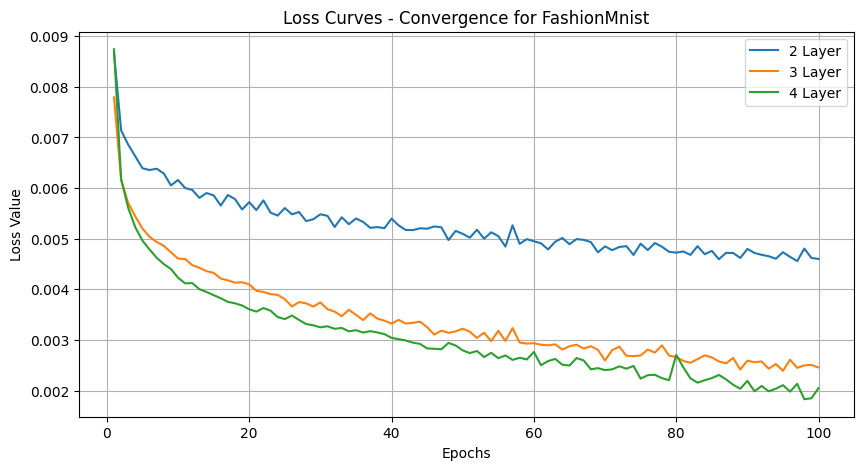

In [ ]:
err_his_2layer_LeakyReLu_fmnist = load_error_history("fmnist_2layer_128_LeakyReLu")
err_his_3layer_LeakyReLu_fmnist = load_error_history("fmnist_3layer_128_64_LeakyReLu")
err_his_4layer_LeakyReLu_fmnist = load_error_history("fmnist_4layer_128_64_32_LeakyReLu")
Err_his_3model_fmnist = [err_his_2layer_LeakyReLu_fmnist, err_his_3layer_LeakyReLu_fmnist, err_his_4layer_LeakyReLu_fmnist]
plot_loss_curves(Err_his_3model_fmnist, A_names, L_names, title = "FashionMnist")